# Initialize Rikai Spark Session

In [2]:
from example import spark

:: loading settings :: url = jar:file:/Users/da/.pyenv/versions/3.8.10/envs/rikai-example/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/da/.ivy2/cache
The jars for the packages stored in: /Users/da/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-26a88848-ff24-4c3c-82de-cf6bf87e4c8e;1.0
	confs: [default]
	found ai.eto#rikai_2.12;0.0.12 in central
	found org.antlr#antlr4-runtime;4.8-1 in local-m2-cache
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.apache.logging.log4j#log4j-api-scala_2.12;12.0 in central
	found org.scala-lang#scala-reflect;2.12.10 in spark-list
	found org.apache.logging.log4j#log4j-api;2.13.2 in central
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.circe#circe-generic_2.12;0.12.3 in central
	found com.chuusai#shapeless_2.12;2.3.3 in spark-list
	found org.typ

# Prepare the Datasets
+ Video: Elepants Dream
+ Coco Labels

In [3]:
from rikai.types import VideoStream, Segment

video = VideoStream("elephants_dream.mp4")

df_video = spark.createDataFrame(
    [(video, Segment(0, 14400))], ["video", "segment"]
)
df_video.createOrReplaceTempView("t_video")

video

VideoStream(uri=elephants_dream.mp4)

In [220]:
spark.conf.set("spark.default.parallelism", "8")

spark.sql("""
select * from parquet.`/tmp/rikai_example/coco_labels`
""").createOrReplaceTempView("coco_labels")

spark.sql("select * from coco_labels where label in ('person', 'door') or id in (56, 24) order by id asc").show()

+---+-------+
| id|  label|
+---+-------+
|  0| person|
| 24|giraffe|
| 56| carrot|
| 70|   door|
+---+-------+



## Prepare the related UDFs

In [178]:
# Extract uri
from rikai.types.vision import Image
from rikai.spark.types.vision import ImageType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from rikai.spark.functions import video_to_images

@udf(returnType=StringType())
def image_to_uri(img: Image):
    return img.uri

@udf(returnType=ImageType())
def uri_to_image(uri: str):
    return Image(uri)

spark.udf.register("image_to_uri", image_to_uri)
spark.udf.register("uri_to_image", uri_to_image)
spark.udf.register("video_to_images", video_to_images)

# Inspect Bounding Boxes on an Image
from rikai.types.vision import Image
from rikai.spark.types.vision import ImageType
from rikai.types.geometry import Box2d
from pyspark.sql.functions import udf
from PIL import ImageDraw

@udf(returnType=ImageType())
def inspect_bounding_boxes(img: Image, boxes, labels):
    pil_image = img.to_pil()
    draw = ImageDraw.Draw(pil_image)
    for i in range(len(labels)):
        box = boxes[i]
        label = labels[i]
        bbox = Box2d(box[0], box[1], box[2], box[3])
        draw.rectangle(bbox.to_numpy().tolist(), outline="green", width=2)
        draw.text([bbox.xmin + 5, bbox.ymin - 10], str(label), fill="red")
    return Image.from_pil(pil_image)

spark.udf.register("inspect_bbox", inspect_bounding_boxes)

21/10/13 15:26:31 WARN SimpleFunctionRegistry: The function image_to_uri replaced a previously registered function.
21/10/13 15:26:31 WARN SimpleFunctionRegistry: The function uri_to_image replaced a previously registered function.
21/10/13 15:26:31 WARN SimpleFunctionRegistry: The function video_to_images replaced a previously registered function.
21/10/13 15:26:31 WARN SimpleFunctionRegistry: The function inspect_bbox replaced a previously registered function.


<function __main__.inspect_bounding_boxes(img: rikai.types.vision.Image, boxes, labels)>

## Create the Yolov5 model

In [180]:
mlflow_tracking_uri = "sqlite:///mlruns.db"
registered_model_name = f"yolov5s-model"

spark.conf.set("rikai.sql.ml.registry.mlflow.tracking_uri", mlflow_tracking_uri)

spark.sql(f"""
    CREATE or replace MODEL mlflow_yolov5_m USING 'mlflow:///{registered_model_name}';
""")

2021-10-13 15:26:55,469 INFO Rikai (mlflow_registry.py:223): Resolving model mlflow_yolov5_m from mlflow:///yolov5s-model
2021-10-13 15:26:55,502 INFO Rikai (base.py:199): Created model inference pandas_udf with name mlflow_yolov5_m_8f220fd1


DataFrame[]

In [191]:
spark.sql("""
create or replace temporary view t_image as
select * from parquet.`/tmp/rikai_example/yolov5_video`
""")

DataFrame[]

In [193]:
spark.sql("""
select * from t_image limit 10
""").show(truncate=False)

+----------------------------+
|uri                         |
+----------------------------+
|/tmp/videostream_5/11372.png|
|/tmp/videostream_5/2677.png |
|/tmp/videostream_5/7875.png |
|/tmp/videostream_5/7370.png |
|/tmp/videostream_5/13387.png|
|/tmp/videostream_5/13102.png|
|/tmp/videostream_5/4831.png |
|/tmp/videostream_5/1011.png |
|/tmp/videostream_5/10984.png|
|/tmp/videostream_5/9365.png |
+----------------------------+



In [211]:
df = spark.sql(f"""
from (
    from (
        select * from t_image limit 10 -- use small dataset for testing purpose
    )
    select
        uri,
        ML_PREDICT(mlflow_yolov5_m, uri) as pred,
        uri_to_image(uri) as image
)
select
    uri,
    pred,
    inspect_bbox(image, pred.boxes, pred.labels) as bbox
where
    array_contains(pred.labels, 0)
""")

In [212]:
rows = df.collect()
rows

[Row(uri='/tmp/videostream_5/11372.png', pred=Row(boxes=[[129.33123779296875, 67.3326416015625, 200.18865966796875, 225.19366455078125]], scores=[0.8737987279891968], labels=[0]), bbox=Image(<embedded>)),
 Row(uri='/tmp/videostream_5/1011.png', pred=Row(boxes=[[325.382080078125, 55.06728744506836, 381.51031494140625, 188.1524658203125], [72.63551330566406, 195.3141326904297, 154.65174865722656, 239.0511016845703]], scores=[0.8362003564834595, 0.6320503950119019], labels=[0, 56]), bbox=Image(<embedded>)),
 Row(uri='/tmp/videostream_5/10984.png', pred=Row(boxes=[[74.52011108398438, 105.11011505126953, 157.02513122558594, 237.53932189941406], [310.34161376953125, 135.32171630859375, 397.908935546875, 238.82965087890625], [187.61605834960938, 38.54850769042969, 271.1911926269531, 240.0]], scores=[0.4124809801578522, 0.40597426891326904, 0.34681206941604614], labels=[0, 24, 0]), bbox=Image(<embedded>))]

In [213]:
rows[0]

Row(uri='/tmp/videostream_5/11372.png', pred=Row(boxes=[[129.33123779296875, 67.3326416015625, 200.18865966796875, 225.19366455078125]], scores=[0.8737987279891968], labels=[0]), bbox=Image(<embedded>))

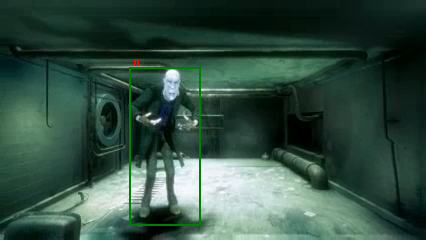

In [214]:
rows[0].bbox

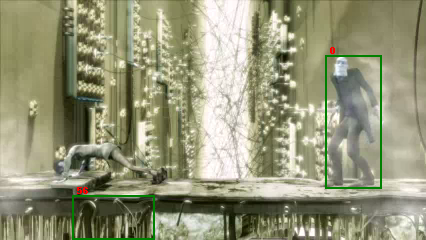

In [215]:
rows[1].bbox

In [223]:
rows[1]

Row(uri='/tmp/videostream_5/1011.png', pred=Row(boxes=[[325.382080078125, 55.06728744506836, 381.51031494140625, 188.1524658203125], [72.63551330566406, 195.3141326904297, 154.65174865722656, 239.0511016845703]], scores=[0.8362003564834595, 0.6320503950119019], labels=[0, 56]), bbox=Image(<embedded>))

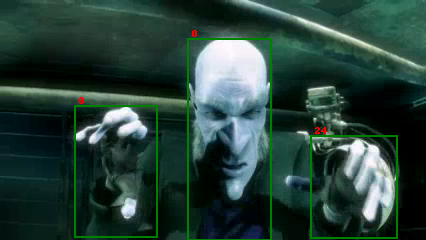

In [217]:
rows[2].bbox

In [221]:
rows[2]

Row(uri='/tmp/videostream_5/10984.png', pred=Row(boxes=[[74.52011108398438, 105.11011505126953, 157.02513122558594, 237.53932189941406], [310.34161376953125, 135.32171630859375, 397.908935546875, 238.82965087890625], [187.61605834960938, 38.54850769042969, 271.1911926269531, 240.0]], scores=[0.4124809801578522, 0.40597426891326904, 0.34681206941604614], labels=[0, 24, 0]), bbox=Image(<embedded>))